In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from sklearn.model_selection import train_test_split

In [24]:
dataset = pd.read_csv('/content/riceClassification.csv', delimiter=',')

In [25]:
dataset.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [29]:
dataset['Class'].replace(1, "Jasmine", inplace=True)
dataset['Class'].replace(0, "Gonen", inplace=True)

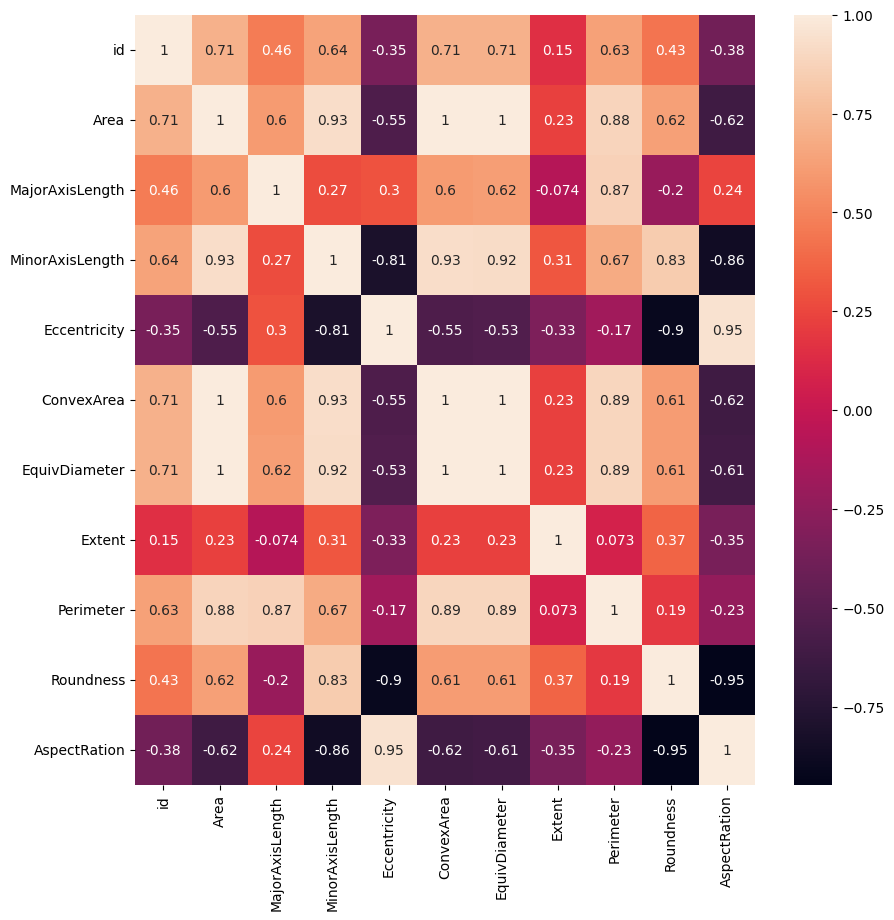

In [55]:
plt.figure(figsize=(10,10))
sns.heatmap(dataset.corr(numeric_only = True), annot=True)
plt.show()

In [30]:
vals = dataset["Class"].unique()
vals

array(['Jasmine', 'Gonen'], dtype=object)

In [56]:
cols_for_clusters = ['MajorAxisLength','MinorAxisLength', "Eccentricity"]
# MajorAxisLength - длина  MinorAxisLength - ширина
df = dataset[cols_for_clusters].copy()

In [57]:
scaler = MinMaxScaler()

scaled = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled, columns=df.columns)

In [58]:
scaled_df.head()

,MajorAxisLength,MinorAxisLength,Eccentricity
0,0.165901,0.614922,0.149139
1,0.005123,0.352934,0.168567
2,0.019803,0.366292,0.188069
3,0.026591,0.363903,0.213671
4,0.100769,0.456247,0.250355


In [59]:
X = scaled_df
y = dataset["Class"].replace(vals, [0, 1])
yvals = dataset["Class"]

<ipython-input-59-4a3bc1df5283>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = dataset["Class"].replace(vals, [0, 1])


In [60]:
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn.cluster import KMeans

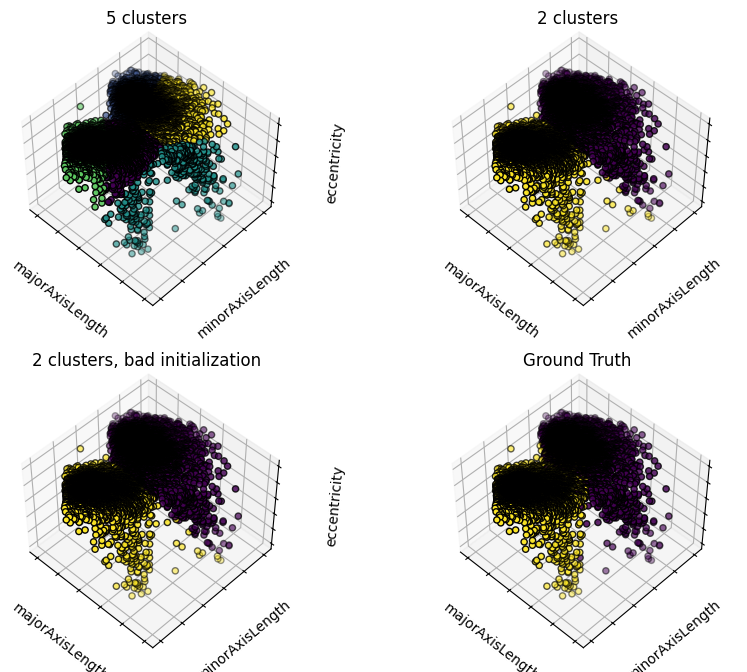

In [62]:
estimators = [
    ("k_means_rice_5", KMeans(n_clusters=5)),
    ("k_means_rice_2", KMeans(n_clusters=2)),
    ("k_means_rice_bad_init", KMeans(n_clusters=2, n_init=1, init="random")),
]

fig = plt.figure(figsize=(10, 8))
titles = ["5 clusters", "2 clusters", "2 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X["MajorAxisLength"], X["MinorAxisLength"], X["Eccentricity"], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("majorAxisLength")
    ax.set_ylabel("minorAxisLength")
    ax.set_zlabel("eccentricity")
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for name, label in [(vals[0], 0), (vals[1], 1)]:
    ds = dataset[dataset["Class"]==name]
    ax.text3D(
        ds["MajorAxisLength"].mean(),
        ds["MinorAxisLength"].mean(),
        ds["Eccentricity"].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax.scatter(X["MajorAxisLength"], X["MinorAxisLength"], X["Eccentricity"], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("majorAxisLength")
ax.set_ylabel("minorAxisLength")
ax.set_zlabel("eccentricity")
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

In [63]:
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score


n_clusters = np.arange(2, 21)

In [64]:
best_metric = [0, 10000, 0,[]]

silhouette_score_values = []
adjusted_rand_score_values = []


for n in n_clusters:

    clusterer = KMeans(n_clusters=n, max_iter=10, n_init=10)
    clusterer.fit(X)
    y_pred = clusterer.predict(X)

    score1 = metrics.silhouette_score(X, y_pred)
    silhouette_score_values.append(score1)

    score2 = metrics.adjusted_rand_score(y, y_pred)
    adjusted_rand_score_values.append(score2)


    if score1 < best_metric[1] and score2 > best_metric[2]:
          best_metric[1] = score1
          best_metric[2] = score2
          best_metric[3] = clusterer.cluster_centers_
          best_metric[0] = n

In [65]:
best_metric

[2,
 0.6133859144960203,
 0.9234216426757201,
 array([[0.69427273, 0.35751667, 0.89644447],
        [0.73253166, 0.74798703, 0.72769171]])]

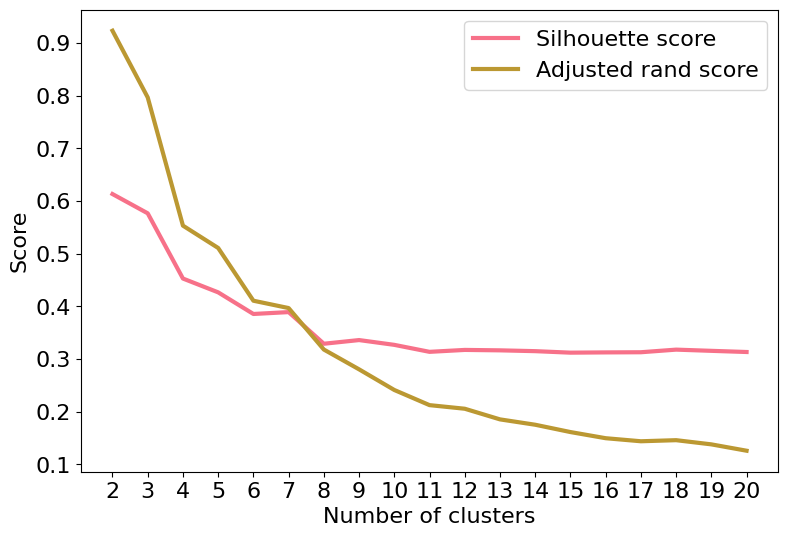

In [66]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)

plt.show()

In [67]:
from scipy.cluster.hierarchy import linkage, dendrogram

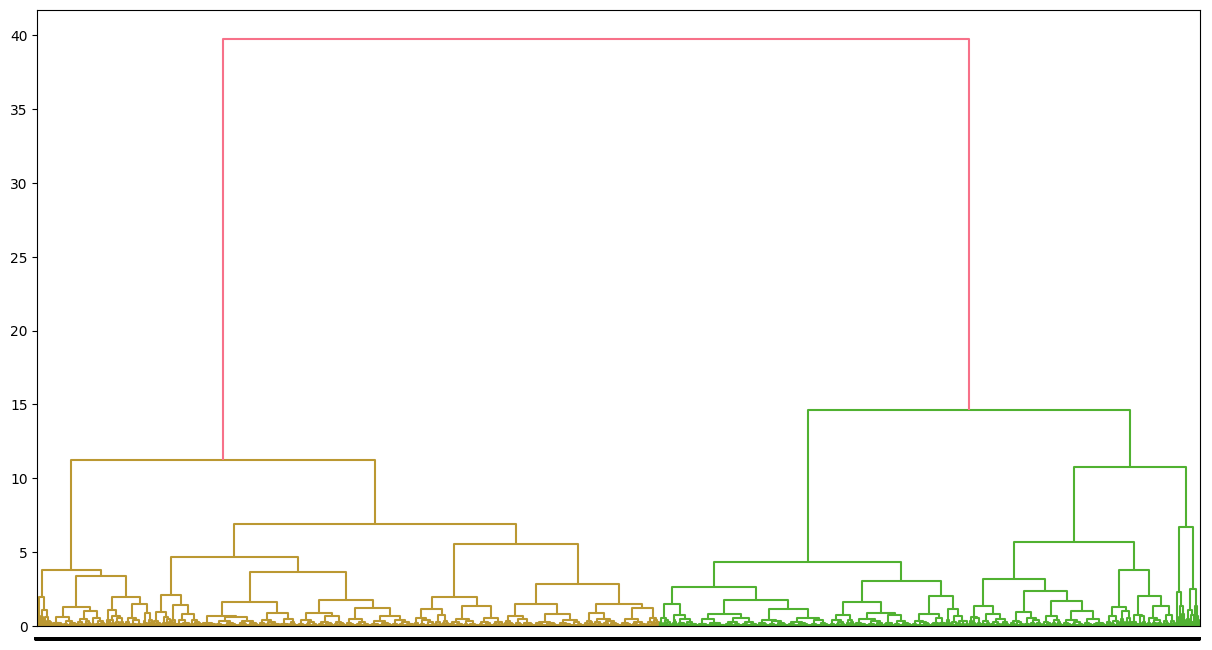

In [69]:
samples = scaled_df.values


mergings = linkage(samples, method='ward')


plt.figure(figsize=(15, 8))

dendrogram(mergings,
           labels=list(y),
           leaf_rotation=90
           )

plt.show()

In [70]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [71]:
mins = X.shape[1]

['y', 'b']


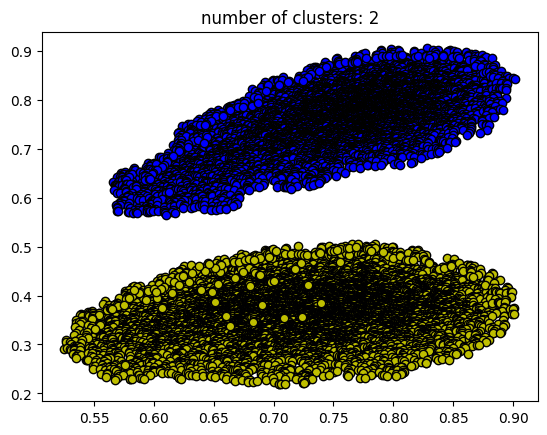

In [133]:
db = DBSCAN(eps=0.02, min_samples=50).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = ['y', 'b']
print(colors)
for k, col in zip(unique_labels, colors):
	if k == -1:
		# Black used for noise.
		col = 'k'

	class_member_mask = (labels == k)

	xy = X[class_member_mask & core_samples_mask]
	plt.plot(xy["MajorAxisLength"], xy["MinorAxisLength"], 'o', markerfacecolor=col,
			markeredgecolor='k',
			markersize=6)

	xy = X[class_member_mask & ~core_samples_mask]
	plt.plot(xy["MajorAxisLength"], xy["MinorAxisLength"], 'o', markerfacecolor=col,
			markeredgecolor='k',
			markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()

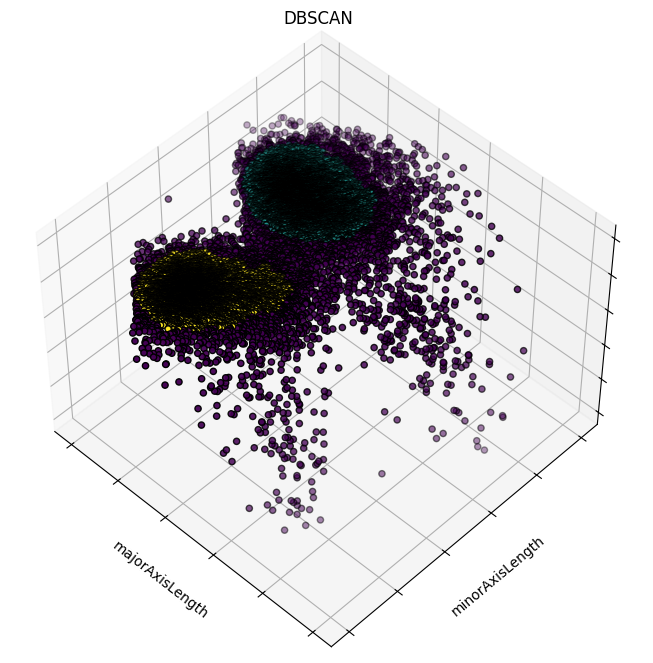

In [134]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d", elev=48, azim=134)

ax.scatter(X["MajorAxisLength"], X["MinorAxisLength"], X["Eccentricity"], c=labels.astype(float), edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("majorAxisLength")
ax.set_ylabel("minorAxisLength")
ax.set_zlabel("eccentricity")
ax.set_title("DBSCAN")

plt.show()

In [135]:
sc = metrics.silhouette_score(X, labels)
print("Silhouette Coefficient:%0.2f" % sc)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index: %0.2f" % ari)

Silhouette Coefficient:0.50
Adjusted Rand Index: 0.68
